## Classification Project

### Imports and Configuration Code

1. Imports and Global ConfigurationThis first code block handles importing all necessary libraries from pandas, numpy, and sklearn. It also sets up global configurations, including file paths for input data and output submission, the random seed for reproducibility, and key parameters derived from the original analysis (e.g., PCA variance threshold, number of features to select). Using os.path.join helps make file paths more portable across operating systems. Warnings are suppressed for a cleaner output during execution.

In [1]:
import numpy as np
import pandas as pd
# Removed: from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For enhanced plotting
import warnings
import os

# --- Global Configuration ---
warnings.filterwarnings('ignore') # Suppress warnings

# Define base directory (Adjust if your project structure is different)
BASE_DATA_DIR = r"D:\Semester10\_Semester10\ML\Project\Classification Project\base_dir"

# Verify base directory exists
if not os.path.exists(BASE_DATA_DIR):
    print(f"WARNING: Base data directory not found at: {BASE_DATA_DIR}")
    print("Please ensure the path is correct for your local machine.")

# Training Data Paths
TRAIN_CAT_FILE = os.path.join(BASE_DATA_DIR, "TRAIN_NEW", "TRAIN_CATEGORICAL_METADATA_new.xlsx")
TRAIN_FCM_FILE = os.path.join(BASE_DATA_DIR, "TRAIN_NEW", "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
TRAIN_QUANT_FILE = os.path.join(BASE_DATA_DIR, "TRAIN_NEW", "TRAIN_QUANTITATIVE_METADATA_new.xlsx")
TRAIN_SOLUTIONS_FILE = os.path.join(BASE_DATA_DIR, "TRAIN_NEW", "TRAINING_SOLUTIONS.xlsx")

# Test Data Paths
TEST_CAT_FILE = os.path.join(BASE_DATA_DIR, "TEST", "TEST_CATEGORICAL.xlsx")
TEST_FCM_FILE = os.path.join(BASE_DATA_DIR, "TEST", "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
TEST_QUANT_FILE = os.path.join(BASE_DATA_DIR, "TEST", "TEST_QUANTITATIVE_METADATA.xlsx")

# Output Path
SUBMISSION_FILE_PATH = os.path.join(BASE_DATA_DIR, 'submission_refactored_local_v1.csv')

# Parameters
SEED = 42
VALIDATION_SPLIT_RATIO = 0.3
PCA_EXPLAINED_VARIANCE = 0.95
NUM_FEATURES_TO_SELECT = 738

### Data Loading Function Code


In [2]:
# --- Data Loading Function ---

def load_dataset(categorical_path, fcm_path, quantitative_path, solutions_path=None):
    """Loads the specified dataset files into pandas DataFrames."""
    try:
        # Check if files exist before attempting to read
        if not os.path.exists(categorical_path): raise FileNotFoundError(f"Categorical file not found: {categorical_path}")
        if not os.path.exists(fcm_path): raise FileNotFoundError(f"FCM file not found: {fcm_path}")
        if not os.path.exists(quantitative_path): raise FileNotFoundError(f"Quantitative file not found: {quantitative_path}")
        if solutions_path and not os.path.exists(solutions_path): raise FileNotFoundError(f"Solutions file not found: {solutions_path}")

        cat_data = pd.read_excel(categorical_path)
        fcm_data = pd.read_csv(fcm_path)
        quant_data = pd.read_excel(quantitative_path)
        target_data = pd.read_excel(solutions_path) if solutions_path else None
        print(f"Data loaded successfully from paths starting with: {os.path.dirname(categorical_path)}")
        return cat_data, fcm_data, quant_data, target_data
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Please check file paths in the configuration block and your Google Drive.")
        raise
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        raise


### Execute Data loading code


In [3]:
# --- Execute Data Loading ---
print("--- Loading Training Data ---")
train_cat_raw, train_fcm_raw, train_quant_raw, train_targets_raw = load_dataset(
    TRAIN_CAT_FILE, TRAIN_FCM_FILE, TRAIN_QUANT_FILE, TRAIN_SOLUTIONS_FILE
)
print("\n--- Loading Test Data ---")
test_cat_raw, test_fcm_raw, test_quant_raw, _ = load_dataset(
    TEST_CAT_FILE, TEST_FCM_FILE, TEST_QUANT_FILE
)

# Store test IDs for the final submission file
test_ids_final = test_cat_raw['participant_id'].copy()

# --- Initial Data Inspection (Training Data) ---
print("\n--- Initial Training Data Shapes ---")
print(f"Categorical: {train_cat_raw.shape}")
print(f"FCM:         {train_fcm_raw.shape}")
print(f"Quantitative:{train_quant_raw.shape}")
print(f"Solutions:   {train_targets_raw.shape}")

print("\n--- Categorical Data Info ---")
train_cat_raw.info()

print("\n--- Quantitative Data Info ---")
train_quant_raw.info()

print("\n--- Initial Missing Value Check (Training Data) ---")
print("Missing values in Categorical:\n", train_cat_raw.isnull().sum()[train_cat_raw.isnull().sum() > 0])
print("\nMissing values in Quantitative:\n", train_quant_raw.isnull().sum()[train_quant_raw.isnull().sum() > 0])
print("\nMissing values in Solutions:\n", train_targets_raw.isnull().sum().sum()) # Should be 0
print("\nMissing values in FCM:\n", train_fcm_raw.isnull().sum().sum()) # Should be 0
print("-" * 50)


--- Loading Training Data ---
Data loaded successfully from paths starting with: D:\Semester10\_Semester10\ML\Project\Classification Project\base_dir\TRAIN_NEW

--- Loading Test Data ---
Data loaded successfully from paths starting with: D:\Semester10\_Semester10\ML\Project\Classification Project\base_dir\TEST

--- Initial Training Data Shapes ---
Categorical: (1213, 10)
FCM:         (1213, 19901)
Quantitative:(1213, 19)
Solutions:   (1213, 3)

--- Categorical Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1170 non-null   float64
 4   PreInt_Demos_Fam_Child_Race    

### Exploratory Data Analysis (EDA) Code

--- EDA: Target Variable Distributions ---
ADHD Outcome Distribution:
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


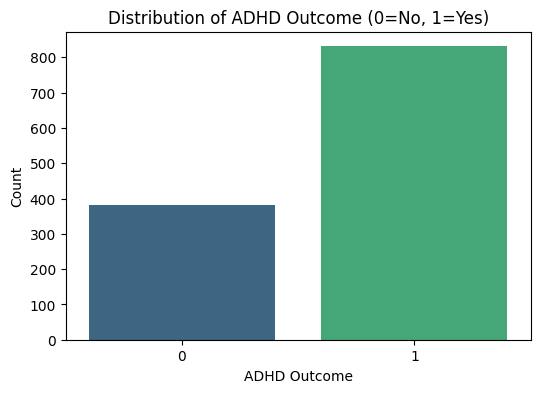


Sex Distribution:
Sex_F
0    797
1    416
Name: count, dtype: int64


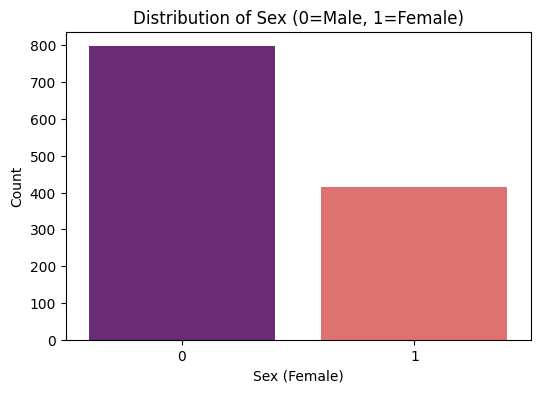


--- EDA: Quantitative Feature Example (Age) ---


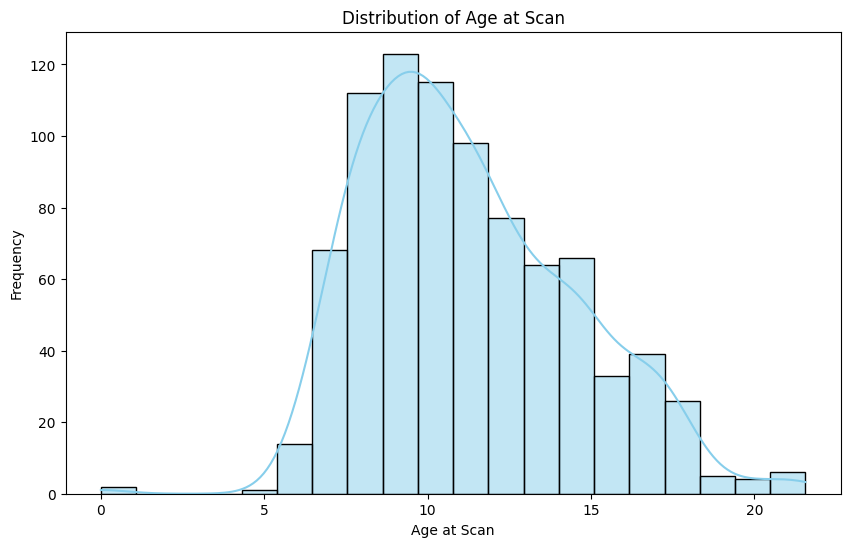


--- EDA: Categorical Feature Example (Parent 1 Education) ---


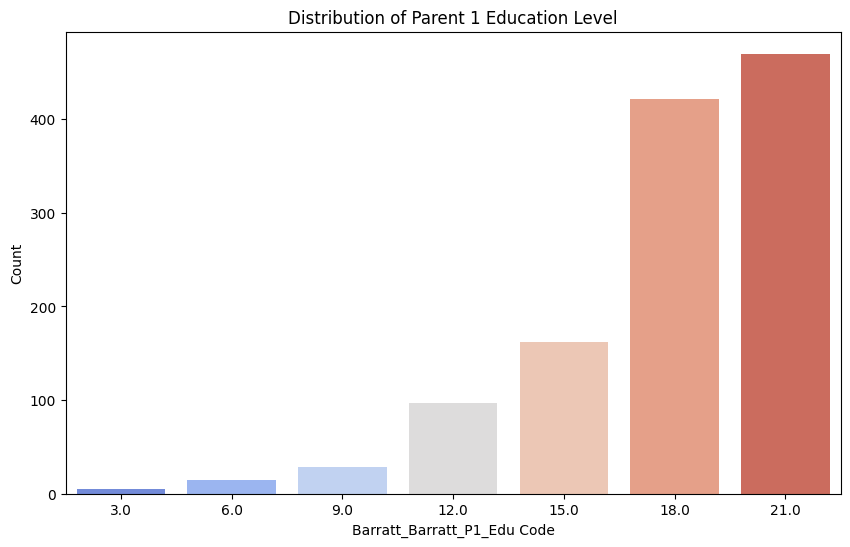

Education Codes:
3= <7th grade, 6=Jr High, 9=Partial HS, 12=HS Grad, 15=Partial College, 18=College, 21=Grad Degree

--- EDA: ADHD Prevalence by Parent 1 Education ---
ADHD Outcome Percentage by Parent 1 Education Level:
Barratt_Barratt_P1_Edu
3.0     80.00
6.0     60.00
9.0     67.86
12.0    72.16
15.0    67.28
18.0    70.07
21.0    67.23
Name: ADHD_Outcome, dtype: float64


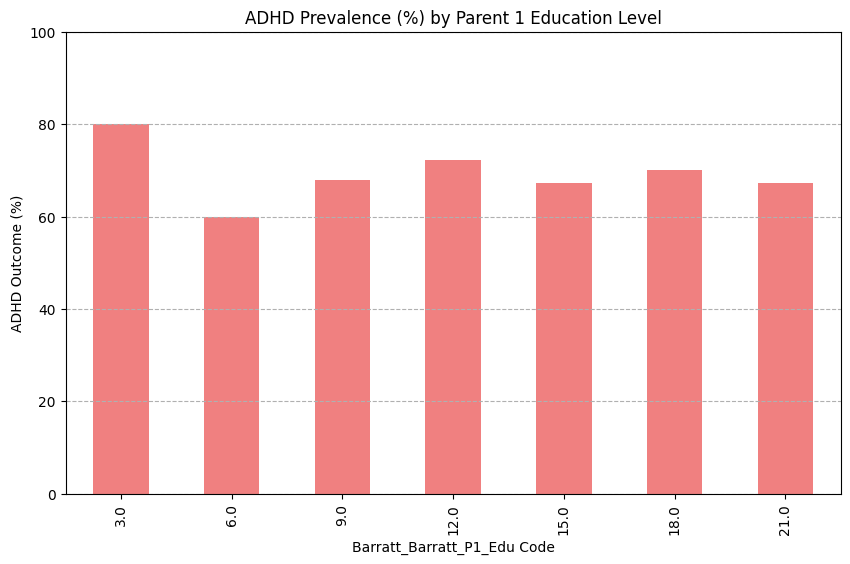

--------------------------------------------------


In [4]:
# --- Exploratory Data Analysis ---
print("--- EDA: Target Variable Distributions ---")

# ADHD Outcome
print("ADHD Outcome Distribution:")
print(train_targets_raw['ADHD_Outcome'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='ADHD_Outcome', data=train_targets_raw, palette='viridis')
plt.title('Distribution of ADHD Outcome (0=No, 1=Yes)')
plt.xlabel('ADHD Outcome')
plt.ylabel('Count')
plt.show()

# Sex Distribution
print("\nSex Distribution:")
print(train_targets_raw['Sex_F'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex_F', data=train_targets_raw, palette='magma')
plt.title('Distribution of Sex (0=Male, 1=Female)')
plt.xlabel('Sex (Female)')
plt.ylabel('Count')
plt.show()

print("\n--- EDA: Quantitative Feature Example (Age) ---")
# Distribution of MRI_Track_Age_at_Scan
plt.figure(figsize=(10, 6))
sns.histplot(train_quant_raw['MRI_Track_Age_at_Scan'], kde=True, color='skyblue', bins=20)
plt.title('Distribution of Age at Scan')
plt.xlabel('Age at Scan')
plt.ylabel('Frequency')
plt.show()

print("\n--- EDA: Categorical Feature Example (Parent 1 Education) ---")
# Distribution of Barratt_Barratt_P1_Edu
plt.figure(figsize=(10, 6))
sns.countplot(data=train_cat_raw, x='Barratt_Barratt_P1_Edu', palette='coolwarm', order = sorted(train_cat_raw['Barratt_Barratt_P1_Edu'].dropna().unique()))
plt.title('Distribution of Parent 1 Education Level')
plt.xlabel('Barratt_Barratt_P1_Edu Code')
plt.ylabel('Count')
# plt.xticks(rotation=45) # Optional rotation if labels overlap
plt.show()
print("Education Codes:\n3= <7th grade, 6=Jr High, 9=Partial HS, 12=HS Grad, 15=Partial College, 18=College, 21=Grad Degree")


print("\n--- EDA: ADHD Prevalence by Parent 1 Education ---")
# Merge targets with categorical for this analysis
temp_eda_df = pd.merge(train_cat_raw[['participant_id', 'Barratt_Barratt_P1_Edu']],
                       train_targets_raw[['participant_id', 'ADHD_Outcome']],
                       on='participant_id')

# Calculate mean ADHD outcome per education level (handles NaNs by default in groupby)
adhd_prevalence_by_edu = temp_eda_df.groupby('Barratt_Barratt_P1_Edu')['ADHD_Outcome'].mean() * 100 # As percentage
print("ADHD Outcome Percentage by Parent 1 Education Level:")
print(adhd_prevalence_by_edu.round(2))

# Optional: Visualize this prevalence
plt.figure(figsize=(10, 6))
adhd_prevalence_by_edu.plot(kind='bar', color='lightcoral')
plt.title('ADHD Prevalence (%) by Parent 1 Education Level')
plt.xlabel('Barratt_Barratt_P1_Edu Code')
plt.ylabel('ADHD Outcome (%)')
plt.ylim(0, 100) # Set y-axis from 0 to 100 for percentage
plt.grid(axis='y', linestyle='--')
plt.show()

print("-" * 50)

# Clean up temporary dataframe
del temp_eda_df


### Pre-processing Function Code

In [5]:
# --- Preprocessing Step Functions ---

# (PCA Function from previous response)
def apply_pca_reduction(fcm_train_df, fcm_test_df, variance_ratio, seed, id_column='participant_id'):
    """Applies PCA for dimensionality reduction on FCM data."""
    train_ids = fcm_train_df[id_column]
    train_features = fcm_train_df.drop(columns=[id_column])
    test_ids = fcm_test_df[id_column]
    test_features = fcm_test_df.drop(columns=[id_column])

    pca_model = PCA(n_components=variance_ratio, random_state=seed)
    fcm_train_reduced = pca_model.fit_transform(train_features)
    fcm_test_reduced = pca_model.transform(test_features)

    n_components = pca_model.n_components_
    print(f"PCA applied. Reduced FCM features to {n_components} components.")

    pca_col_names = [f'PC_{i+1}' for i in range(n_components)]
    fcm_train_pca_df = pd.DataFrame(fcm_train_reduced, index=train_ids.index, columns=pca_col_names)
    fcm_train_pca_df.insert(0, id_column, train_ids)

    fcm_test_pca_df = pd.DataFrame(fcm_test_reduced, index=test_ids.index, columns=pca_col_names)
    fcm_test_pca_df.insert(0, id_column, test_ids)

    return fcm_train_pca_df, fcm_test_pca_df, pca_model

# (Categorical Encoding Function from previous response)
def encode_categorical_features(cat_train_df, cat_test_df, id_column='participant_id'):
    """Performs one-hot encoding on categorical features."""
    for df in [cat_train_df, cat_test_df]:
        for col in df.select_dtypes(include='int').columns:
             if col != id_column:
                  df[col] = df[col].astype('category')

    train_id_series = cat_train_df[id_column]
    test_id_series = cat_test_df[id_column]
    train_features = cat_train_df.drop(columns=[id_column])
    test_features = cat_test_df.drop(columns=[id_column])

    train_encoded = pd.get_dummies(train_features, drop_first=True, dummy_na=False)
    bool_cols_train = train_encoded.select_dtypes(include=bool).columns
    train_encoded[bool_cols_train] = train_encoded[bool_cols_train].astype(int)

    test_encoded = pd.get_dummies(test_features, drop_first=True, dummy_na=False)
    bool_cols_test = test_encoded.select_dtypes(include=bool).columns
    test_encoded[bool_cols_test] = test_encoded[bool_cols_test].astype(int)

    train_cols = train_encoded.columns
    test_encoded = test_encoded.reindex(columns=train_cols, fill_value=0)

    cat_train_encoded_df = pd.concat([train_id_series, train_encoded], axis=1)
    cat_test_encoded_df = pd.concat([test_id_series, test_encoded], axis=1)

    print("Categorical features encoded and aligned.")
    return cat_train_encoded_df, cat_test_encoded_df, train_cols

# (Data Merging Function from previous response)
def merge_all_data(cat_data, fcm_data, quant_data, target_data=None, id_column='participant_id'):
    """Merges categorical, FCM, quantitative, and optionally target dataframes."""
    merged_df = pd.merge(cat_data, fcm_data, on=id_column, how='inner')
    merged_df = pd.merge(merged_df, quant_data, on=id_column, how='inner')
    if target_data is not None:
        target_cols_to_merge = [id_column, 'ADHD_Outcome', 'Sex_F']
        merged_df = pd.merge(merged_df, target_data[target_cols_to_merge], on=id_column, how='inner')
    print(f"Dataframes successfully merged. Resulting shape: {merged_df.shape}")
    return merged_df

# (Missing Value Imputation Function from previous response)
def impute_missing_values(df, train_means=None, train_modes=None):
    """Imputes missing values using mean for numeric and mode for categoricals."""
    initial_na_count = df.isna().sum().sum()
    print(f"Initial check: {initial_na_count} missing values in the current DataFrame.")
    if initial_na_count == 0:
        print("No missing values to impute.")
        return df, train_means, train_modes

    means_used = {}
    modes_used = {}

    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            fill_value = train_means.get(col) if train_means is not None else df[col].mean()
            if pd.isna(fill_value):
                 fill_value = 0
                 print(f"Warning: Mean for column '{col}' was NaN. Filling with 0.")
            df[col].fillna(fill_value, inplace=True)
            means_used[col] = fill_value

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
         if df[col].isnull().any():
             if df[col].dtype.name != 'category':
                  try:
                      df[col] = df[col].astype('category')
                  except TypeError:
                      print(f"Warning: Could not convert column {col} to category. Skipping mode imputation.")
                      continue
             fill_value = train_modes.get(col) if train_modes is not None else df[col].mode()[0]
             df[col].fillna(fill_value, inplace=True)
             modes_used[col] = fill_value

    final_na_count = df.isna().sum().sum()
    print(f"Imputation complete. Remaining missing values: {final_na_count}")
    if final_na_count > 0:
        print(f"Warning: {final_na_count} missing values could not be imputed.")

    calculated_means = pd.Series(means_used) if train_means is None else None
    calculated_modes = pd.Series(modes_used) if train_modes is None else None

    return df, calculated_means, calculated_modes

# (Feature Scaling Function from previous response)
def scale_data(train_data, val_data, test_data):
    """Scales features using MinMaxScaler."""
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    print("Data scaling complete using MinMaxScaler.")
    return train_scaled, val_scaled, test_scaled, scaler

# (Feature Selection Function from previous response)
def perform_feature_selection(X_train, y_train, k, X_val, X_test):
    """Selects top K features based on mutual information and combines masks."""
    print(f"Performing feature selection to get top ~{k} combined features...")
    n_features = X_train.shape[1]
    k_safe = min(k, n_features)
    if k_safe < k:
        print(f"Warning: Requested k={k} features, but only {n_features} available. Using k={k_safe}.")

    selector_adhd = SelectKBest(score_func=mutual_info_classif, k=k_safe)
    selector_adhd.fit(X_train, y_train['ADHD_Outcome'])
    adhd_mask = selector_adhd.get_support()
    print(f"Selected {np.sum(adhd_mask)} features based on ADHD_Outcome.")

    selector_sex = SelectKBest(score_func=mutual_info_classif, k=k_safe)
    selector_sex.fit(X_train, y_train['Sex_F'])
    sex_mask = selector_sex.get_support()
    print(f"Selected {np.sum(sex_mask)} features based on Sex_F.")

    combined_feature_mask = adhd_mask | sex_mask
    num_selected = np.sum(combined_feature_mask)
    print(f"Combined mask selects {num_selected} features.")

    X_train_sel = X_train[:, combined_feature_mask]
    X_val_sel = X_val[:, combined_feature_mask]
    X_test_sel = X_test[:, combined_feature_mask]

    return X_train_sel, X_val_sel, X_test_sel, combined_feature_mask


### Execute Preprocessing Pipeline Code

In [6]:
# --- Execute Preprocessing Steps ---

# Apply PCA
print("--- Applying PCA ---")
train_fcm_pca_df, test_fcm_pca_df, pca_model = apply_pca_reduction(
    train_fcm_raw, test_fcm_raw, PCA_EXPLAINED_VARIANCE, SEED
)
print(f"Train FCM PCA shape: {train_fcm_pca_df.shape}, Test FCM PCA shape: {test_fcm_pca_df.shape}")
print("-" * 50)

# Encode Categorical
print("--- Encoding Categorical Features ---")
train_cat_encoded_df, test_cat_encoded_df, train_encoded_cols = encode_categorical_features(
    train_cat_raw, test_cat_raw
)
print(f"Train Cat Encoded shape: {train_cat_encoded_df.shape}, Test Cat Encoded shape: {test_cat_encoded_df.shape}")
print("-" * 50)

# Merge Data
print("--- Merging Data Sources ---")
train_merged = merge_all_data(train_cat_encoded_df, train_fcm_pca_df, train_quant_raw, train_targets_raw)
test_merged = merge_all_data(test_cat_encoded_df, test_fcm_pca_df, test_quant_raw)
print("-" * 50)

# Impute Missing Values
print("--- Imputing Missing Values ---")
train_imputed, train_means_used, train_modes_used = impute_missing_values(train_merged)
test_imputed, _, _ = impute_missing_values(test_merged, train_means=train_means_used, train_modes=train_modes_used)
print("-" * 50)

# Align Columns (Post-Imputation/Merge)
print("--- Aligning Columns ---")
train_feature_cols = train_imputed.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F']).columns
test_id_col = test_imputed['participant_id']
test_imputed = test_imputed.reindex(columns=list(train_feature_cols), fill_value=0) # Align test to train feature cols
test_imputed.insert(0, 'participant_id', test_id_col) # Add ID back
print("Columns aligned.")
print(f"Final Train imputed shape: {train_imputed.shape}, Final Test imputed shape: {test_imputed.shape}")
print("-" * 50)

# Prepare Features (X) and Targets (y)
print("--- Preparing Features and Targets ---")
X_all = train_imputed.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F'])
y_all = train_imputed[['ADHD_Outcome', 'Sex_F']]
X_test_prepared = test_imputed.drop(columns=['participant_id'])

# Ensure column names are strings
X_all.columns = X_all.columns.astype(str)
X_test_prepared.columns = X_test_prepared.columns.astype(str)
print(f"Prepared X_all shape: {X_all.shape}, y_all shape: {y_all.shape}, X_test_prepared shape: {X_test_prepared.shape}")
print("-" * 50)

# Split Data into Training and Validation Sets
print("--- Splitting Data ---")
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=VALIDATION_SPLIT_RATIO, random_state=SEED, stratify=y_all['Sex_F']
)
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")
print("-" * 50)

# Scale Features
print("--- Scaling Features ---")
X_train_s, X_val_s, X_test_s, scaler_model = scale_data(X_train.values, X_val.values, X_test_prepared.values)
print("-" * 50)

# Select Features
print("--- Selecting Features ---")
X_train_sel, X_val_sel, X_test_sel, feature_selection_mask = perform_feature_selection(
    X_train_s, y_train, NUM_FEATURES_TO_SELECT, X_val_s, X_test_s
)
print(f"Shape after feature selection - Train: {X_train_sel.shape}, Val: {X_val_sel.shape}, Test: {X_test_sel.shape}")
print("-" * 50)



--- Applying PCA ---
PCA applied. Reduced FCM features to 902 components.
Train FCM PCA shape: (1213, 903), Test FCM PCA shape: (304, 903)
--------------------------------------------------
--- Encoding Categorical Features ---
Categorical features encoded and aligned.
Train Cat Encoded shape: (1213, 16), Test Cat Encoded shape: (304, 16)
--------------------------------------------------
--- Merging Data Sources ---
Dataframes successfully merged. Resulting shape: (1213, 938)
Dataframes successfully merged. Resulting shape: (304, 936)
--------------------------------------------------
--- Imputing Missing Values ---
Initial check: 1115 missing values in the current DataFrame.
Imputation complete. Remaining missing values: 0
Initial check: 459 missing values in the current DataFrame.
Imputation complete. Remaining missing values: 0
--------------------------------------------------
--- Aligning Columns ---
Columns aligned.
Final Train imputed shape: (1213, 938), Final Test imputed shap

### Model Training, Evaluation, Submission Functions Code

In [7]:
# --- Model Training, Evaluation, Submission Functions ---

# (Model Training Function from previous response)
def train_final_model(X_train_final, y_train_final):
    """Trains the final MultiOutput Logistic Regression model."""
    base_classifier = LogisticRegression(
        C=0.1,
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        class_weight='balanced',
        random_state=SEED,
        max_iter=1500
    )
    multi_output_model = MultiOutputClassifier(base_classifier, n_jobs=-1)
    print("Training final model (Tuned Logistic Regression)...")
    multi_output_model.fit(X_train_final, y_train_final)
    print("Model training complete.")
    return multi_output_model

# (Model Evaluation Function from previous response - updated to include plots)
def evaluate_model(model, X_val_final, y_val_final):
    """Evaluates the model on the validation set and prints metrics/plots."""
    print("\n--- Evaluating model on validation set ---")
    y_pred_val = model.predict(X_val_final)
    y_pred_adhd_val = y_pred_val[:, 0]
    y_pred_sex_val = y_pred_val[:, 1]
    y_true_adhd_val = y_val_final['ADHD_Outcome'].values
    y_true_sex_val = y_val_final['Sex_F'].values

    print("Validation Report for ADHD_Outcome:")
    print(classification_report(y_true_adhd_val, y_pred_adhd_val))
    print("Validation Report for Sex_F:")
    print(classification_report(y_true_sex_val, y_pred_sex_val))

    adhd_f1 = f1_score(y_true_adhd_val, y_pred_adhd_val)
    sex_f1 = f1_score(y_true_sex_val, y_pred_sex_val)
    adhd_acc = accuracy_score(y_true_adhd_val, y_pred_adhd_val)
    sex_acc = accuracy_score(y_true_sex_val, y_pred_sex_val)

    print(f"Validation ADHD Accuracy: {adhd_acc:.4f}, F1-Score: {adhd_f1:.4f}")
    print(f"Validation Sex Accuracy: {sex_acc:.4f}, F1-Score: {sex_f1:.4f}")

    # Plot Confusion Matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Validation Set Confusion Matrices')

    # ADHD Confusion Matrix
    cm_adhd = confusion_matrix(y_true_adhd_val, y_pred_adhd_val)
    disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=[0, 1])
    disp_adhd.plot(ax=axes[0], cmap='Blues')
    axes[0].set_title('ADHD Outcome Confusion Matrix')

    # Sex Confusion Matrix
    cm_sex = confusion_matrix(y_true_sex_val, y_pred_sex_val)
    disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=[0, 1])
    disp_sex.plot(ax=axes[1], cmap='Greens')
    axes[1].set_title('Sex (Female) Confusion Matrix')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    print("-" * 50)


# (Submission Generation Function from previous response)
def generate_submission(model, X_test_final, test_ids, output_path):
    """Generates predictions on the test set and saves the submission file."""
    print("Generating predictions for the test set...")
    test_preds = model.predict(X_test_final)

    submission_output = pd.DataFrame({
        'participant_id': test_ids,
        'ADHD_Outcome': test_preds[:, 0],
        'Sex_F': test_preds[:, 1]
    })

    submission_output['ADHD_Outcome'] = submission_output['ADHD_Outcome'].astype(int)
    submission_output['Sex_F'] = submission_output['Sex_F'].astype(int)

    try:
        submission_output.to_csv(output_path, index=False)
        print(f"Submission file successfully saved to: {output_path}")
    except Exception as e:
        print(f"Error saving submission file: {e}")


### Model Exploarion Setup code

In [8]:
# --- Model Exploration Setup ---

# Import necessary classifiers and evaluation tools if not already imported
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported for the results summary

# Dictionary to store evaluation results
evaluation_results = {}


### KNN Model Code


--- Training and Evaluating: KNN ---

Validation Report for ADHD_Outcome (KNN):
              precision    recall  f1-score   support

           0       0.34      0.95      0.50       114
           1       0.87      0.16      0.26       250

    accuracy                           0.40       364
   macro avg       0.60      0.55      0.38       364
weighted avg       0.70      0.40      0.34       364

Validation Report for Sex_F (KNN):
              precision    recall  f1-score   support

           0       0.71      0.31      0.43       239
           1       0.36      0.75      0.49       125

    accuracy                           0.46       364
   macro avg       0.54      0.53      0.46       364
weighted avg       0.59      0.46      0.45       364

KNN - ADHD Accuracy: 0.4038, F1-Score: 0.2644
KNN - Sex Accuracy: 0.4643, F1-Score: 0.4909


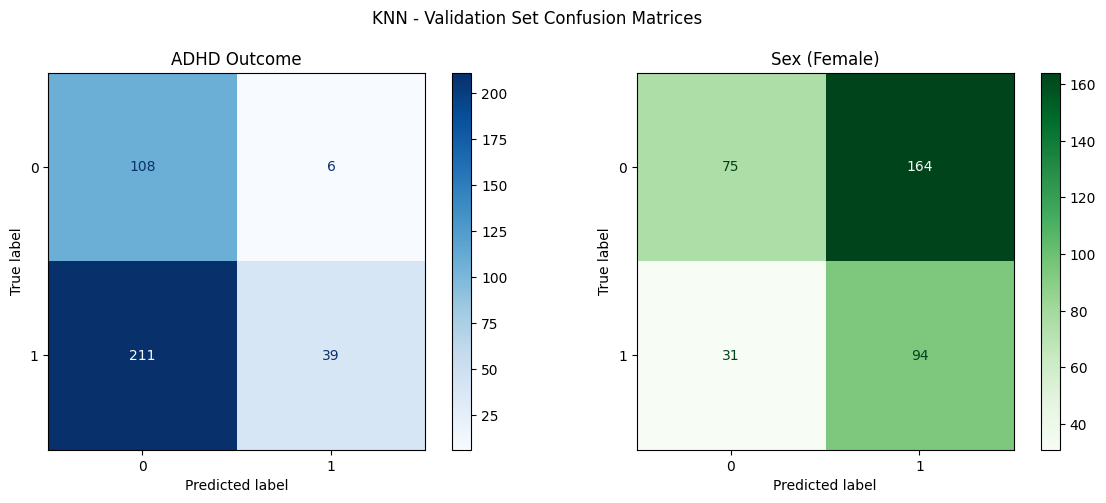

--------------------------------------------------


In [9]:
# --- K-Nearest Neighbors (KNN) ---
model_name = 'KNN'
print(f"\n--- Training and Evaluating: {model_name} ---")

# Define the model
knn_model = MultiOutputClassifier(
    KNeighborsClassifier(n_neighbors=5, n_jobs=-1) # Using default neighbors=5
)

# Train the model
knn_model.fit(X_train_sel, y_train)

# Predict on the validation set
y_pred_val_knn = knn_model.predict(X_val_sel)
y_pred_adhd_val = y_pred_val_knn[:, 0]
y_pred_sex_val = y_pred_val_knn[:, 1]
y_true_adhd_val = y_val['ADHD_Outcome'].values
y_true_sex_val = y_val['Sex_F'].values

# Print Classification Reports
print(f"\nValidation Report for ADHD_Outcome ({model_name}):")
print(classification_report(y_true_adhd_val, y_pred_adhd_val))
print(f"Validation Report for Sex_F ({model_name}):")
print(classification_report(y_true_sex_val, y_pred_sex_val))

# Calculate and store metrics
adhd_f1 = f1_score(y_true_adhd_val, y_pred_adhd_val)
sex_f1 = f1_score(y_true_sex_val, y_pred_sex_val)
adhd_acc = accuracy_score(y_true_adhd_val, y_pred_adhd_val)
sex_acc = accuracy_score(y_true_sex_val, y_pred_sex_val)
evaluation_results[model_name] = {
    'ADHD_Accuracy': adhd_acc, 'ADHD_F1': adhd_f1,
    'Sex_Accuracy': sex_acc, 'Sex_F1': sex_f1
}
print(f"{model_name} - ADHD Accuracy: {adhd_acc:.4f}, F1-Score: {adhd_f1:.4f}")
print(f"{model_name} - Sex Accuracy: {sex_acc:.4f}, F1-Score: {sex_f1:.4f}")

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{model_name} - Validation Set Confusion Matrices')
cm_adhd = confusion_matrix(y_true_adhd_val, y_pred_adhd_val)
disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=[0, 1])
disp_adhd.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('ADHD Outcome')
cm_sex = confusion_matrix(y_true_sex_val, y_pred_sex_val)
disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=[0, 1])
disp_sex.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Sex (Female)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("-" * 50)


### Random Forest Model code


--- Training and Evaluating: RandomForest ---

Validation Report for ADHD_Outcome (RandomForest):
              precision    recall  f1-score   support

           0       0.72      0.37      0.49       114
           1       0.76      0.94      0.84       250

    accuracy                           0.76       364
   macro avg       0.74      0.65      0.67       364
weighted avg       0.75      0.76      0.73       364

Validation Report for Sex_F (RandomForest):
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       239
           1       0.33      0.01      0.02       125

    accuracy                           0.65       364
   macro avg       0.49      0.50      0.40       364
weighted avg       0.55      0.65      0.52       364

RandomForest - ADHD Accuracy: 0.7582, F1-Score: 0.8417
RandomForest - Sex Accuracy: 0.6538, F1-Score: 0.0156


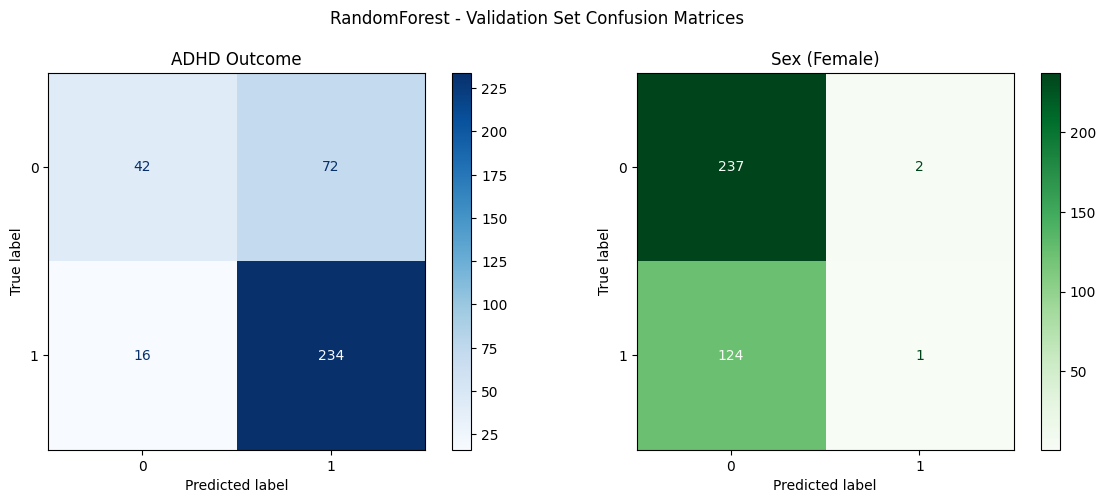

--------------------------------------------------


In [10]:
# --- Random Forest ---
model_name = 'RandomForest'
print(f"\n--- Training and Evaluating: {model_name} ---")

# Define the model
rf_model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=150, class_weight='balanced',
                           max_depth=10, min_samples_leaf=5, # From exploration/tuning
                           random_state=SEED, n_jobs=-1)
)

# Train the model
rf_model.fit(X_train_sel, y_train)

# Predict on the validation set
y_pred_val_rf = rf_model.predict(X_val_sel)
y_pred_adhd_val = y_pred_val_rf[:, 0]
y_pred_sex_val = y_pred_val_rf[:, 1]
y_true_adhd_val = y_val['ADHD_Outcome'].values
y_true_sex_val = y_val['Sex_F'].values

# Print Classification Reports
print(f"\nValidation Report for ADHD_Outcome ({model_name}):")
print(classification_report(y_true_adhd_val, y_pred_adhd_val))
print(f"Validation Report for Sex_F ({model_name}):")
print(classification_report(y_true_sex_val, y_pred_sex_val))

# Calculate and store metrics
adhd_f1 = f1_score(y_true_adhd_val, y_pred_adhd_val)
sex_f1 = f1_score(y_true_sex_val, y_pred_sex_val)
adhd_acc = accuracy_score(y_true_adhd_val, y_pred_adhd_val)
sex_acc = accuracy_score(y_true_sex_val, y_pred_sex_val)
evaluation_results[model_name] = {
    'ADHD_Accuracy': adhd_acc, 'ADHD_F1': adhd_f1,
    'Sex_Accuracy': sex_acc, 'Sex_F1': sex_f1
}
print(f"{model_name} - ADHD Accuracy: {adhd_acc:.4f}, F1-Score: {adhd_f1:.4f}")
print(f"{model_name} - Sex Accuracy: {sex_acc:.4f}, F1-Score: {sex_f1:.4f}")

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{model_name} - Validation Set Confusion Matrices')
cm_adhd = confusion_matrix(y_true_adhd_val, y_pred_adhd_val)
disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=[0, 1])
disp_adhd.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('ADHD Outcome')
cm_sex = confusion_matrix(y_true_sex_val, y_pred_sex_val)
disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=[0, 1])
disp_sex.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Sex (Female)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("-" * 50)


### Neural Network (MLP) Model code


--- Training and Evaluating: NeuralNetwork ---

Validation Report for ADHD_Outcome (NeuralNetwork):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.69      1.00      0.81       250

    accuracy                           0.69       364
   macro avg       0.34      0.50      0.41       364
weighted avg       0.47      0.69      0.56       364

Validation Report for Sex_F (NeuralNetwork):
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       239
           1       0.00      0.00      0.00       125

    accuracy                           0.66       364
   macro avg       0.33      0.50      0.40       364
weighted avg       0.43      0.66      0.52       364

NeuralNetwork - ADHD Accuracy: 0.6868, F1-Score: 0.8143
NeuralNetwork - Sex Accuracy: 0.6566, F1-Score: 0.0000


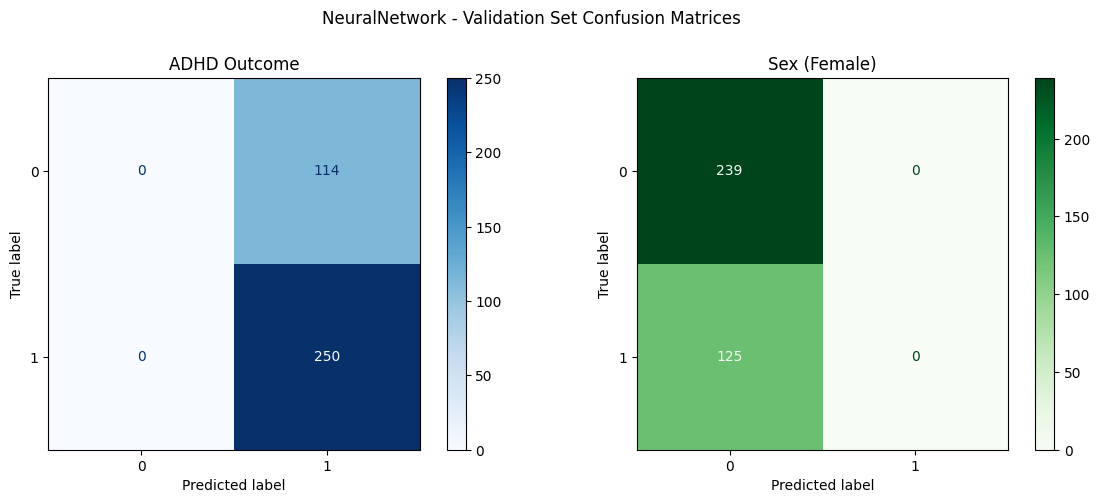

--------------------------------------------------


In [11]:
# --- Neural Network (MLP) ---
model_name = 'NeuralNetwork'
print(f"\n--- Training and Evaluating: {model_name} ---")

# Define the model
nn_model = MultiOutputClassifier(
    MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                  alpha=0.001, learning_rate='adaptive', max_iter=500,
                  random_state=SEED, early_stopping=True, validation_fraction=0.1) # Added early stopping
)

# Train the model
nn_model.fit(X_train_sel, y_train)

# Predict on the validation set
y_pred_val_nn = nn_model.predict(X_val_sel)
y_pred_adhd_val = y_pred_val_nn[:, 0]
y_pred_sex_val = y_pred_val_nn[:, 1]
y_true_adhd_val = y_val['ADHD_Outcome'].values
y_true_sex_val = y_val['Sex_F'].values

# Print Classification Reports
print(f"\nValidation Report for ADHD_Outcome ({model_name}):")
print(classification_report(y_true_adhd_val, y_pred_adhd_val))
print(f"Validation Report for Sex_F ({model_name}):")
print(classification_report(y_true_sex_val, y_pred_sex_val))

# Calculate and store metrics
adhd_f1 = f1_score(y_true_adhd_val, y_pred_adhd_val)
sex_f1 = f1_score(y_true_sex_val, y_pred_sex_val)
adhd_acc = accuracy_score(y_true_adhd_val, y_pred_adhd_val)
sex_acc = accuracy_score(y_true_sex_val, y_pred_sex_val)
evaluation_results[model_name] = {
    'ADHD_Accuracy': adhd_acc, 'ADHD_F1': adhd_f1,
    'Sex_Accuracy': sex_acc, 'Sex_F1': sex_f1
}
print(f"{model_name} - ADHD Accuracy: {adhd_acc:.4f}, F1-Score: {adhd_f1:.4f}")
print(f"{model_name} - Sex Accuracy: {sex_acc:.4f}, F1-Score: {sex_f1:.4f}")

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{model_name} - Validation Set Confusion Matrices')
cm_adhd = confusion_matrix(y_true_adhd_val, y_pred_adhd_val)
disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=[0, 1])
disp_adhd.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('ADHD Outcome')
cm_sex = confusion_matrix(y_true_sex_val, y_pred_sex_val)
disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=[0, 1])
disp_sex.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Sex (Female)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("-" * 50)


### Tuned Logistic Regression Model code


--- Training and Evaluating: LogisticRegression_Tuned ---

Validation Report for ADHD_Outcome (LogisticRegression_Tuned):
              precision    recall  f1-score   support

           0       0.60      0.79      0.68       114
           1       0.89      0.76      0.82       250

    accuracy                           0.77       364
   macro avg       0.74      0.77      0.75       364
weighted avg       0.80      0.77      0.78       364

Validation Report for Sex_F (LogisticRegression_Tuned):
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       239
           1       0.46      0.63      0.53       125

    accuracy                           0.62       364
   macro avg       0.61      0.62      0.60       364
weighted avg       0.66      0.62      0.62       364

LogisticRegression_Tuned - ADHD Accuracy: 0.7692, F1-Score: 0.8190
LogisticRegression_Tuned - Sex Accuracy: 0.6154, F1-Score: 0.5302


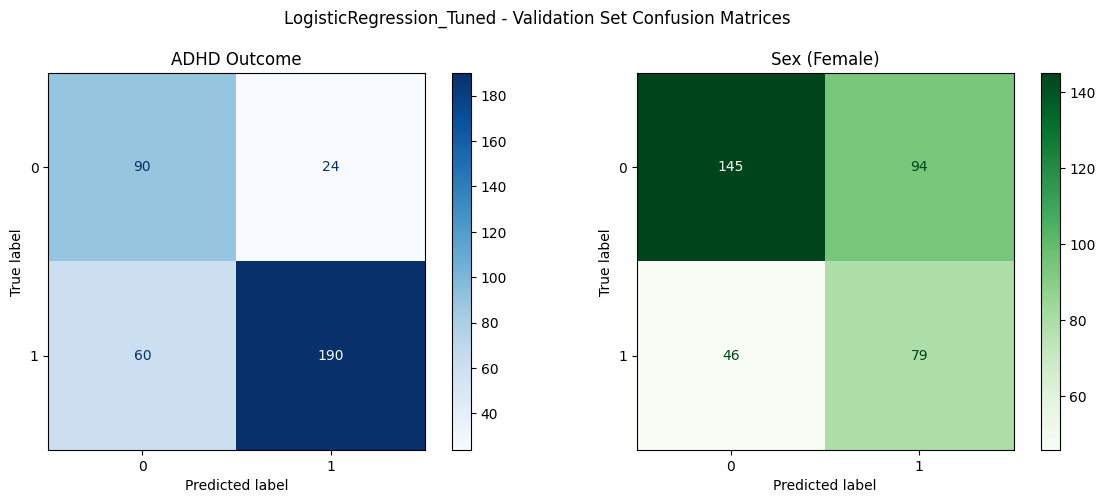

--------------------------------------------------


In [12]:
# --- Tuned Logistic Regression ---
model_name = 'LogisticRegression_Tuned'
print(f"\n--- Training and Evaluating: {model_name} ---")

# Define the model using the best parameters found previously
lr_tuned_model = MultiOutputClassifier(
    LogisticRegression(
        C=0.1, penalty='elasticnet', solver='saga', l1_ratio=0.5,
        class_weight='balanced', random_state=SEED, max_iter=1500
    ), n_jobs=-1
)

# Train the model
lr_tuned_model.fit(X_train_sel, y_train)

# Predict on the validation set
y_pred_val_lr = lr_tuned_model.predict(X_val_sel)
y_pred_adhd_val = y_pred_val_lr[:, 0]
y_pred_sex_val = y_pred_val_lr[:, 1]
y_true_adhd_val = y_val['ADHD_Outcome'].values
y_true_sex_val = y_val['Sex_F'].values

# Print Classification Reports
print(f"\nValidation Report for ADHD_Outcome ({model_name}):")
print(classification_report(y_true_adhd_val, y_pred_adhd_val))
print(f"Validation Report for Sex_F ({model_name}):")
print(classification_report(y_true_sex_val, y_pred_sex_val))

# Calculate and store metrics
adhd_f1 = f1_score(y_true_adhd_val, y_pred_adhd_val)
sex_f1 = f1_score(y_true_sex_val, y_pred_sex_val)
adhd_acc = accuracy_score(y_true_adhd_val, y_pred_adhd_val)
sex_acc = accuracy_score(y_true_sex_val, y_pred_sex_val)
evaluation_results[model_name] = {
    'ADHD_Accuracy': adhd_acc, 'ADHD_F1': adhd_f1,
    'Sex_Accuracy': sex_acc, 'Sex_F1': sex_f1
}
print(f"{model_name} - ADHD Accuracy: {adhd_acc:.4f}, F1-Score: {adhd_f1:.4f}")
print(f"{model_name} - Sex Accuracy: {sex_acc:.4f}, F1-Score: {sex_f1:.4f}")

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'{model_name} - Validation Set Confusion Matrices')
cm_adhd = confusion_matrix(y_true_adhd_val, y_pred_adhd_val)
disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=[0, 1])
disp_adhd.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('ADHD Outcome')
cm_sex = confusion_matrix(y_true_sex_val, y_pred_sex_val)
disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=[0, 1])
disp_sex.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Sex (Female)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("-" * 50)

# Assign the best model (based on prior analysis) for retraining
best_model = lr_tuned_model


### Model Evaluaion Summary

In [13]:
# --- Summarize Evaluation Results ---
print("\n--- Summary of Model Performance on Validation Set ---")
results_df = pd.DataFrame(evaluation_results).T # Transpose for models as rows
print(results_df)
print("-" * 50)

# You can add comments here discussing which model performed best based on the results_df
# e.g., "Based on the validation F1-scores, LogisticRegression_Tuned appears to be the best performing model overall, especially for ADHD prediction."
# The 'best_model' variable was already assigned to the tuned LR model in the previous step.



--- Summary of Model Performance on Validation Set ---
                          ADHD_Accuracy   ADHD_F1  Sex_Accuracy    Sex_F1
KNN                            0.403846  0.264407      0.464286  0.490862
RandomForest                   0.758242  0.841727      0.653846  0.015625
NeuralNetwork                  0.686813  0.814332      0.656593  0.000000
LogisticRegression_Tuned       0.769231  0.818966      0.615385  0.530201
--------------------------------------------------


### Main Execution Code

In [14]:
# --- Main Execution ---

if __name__ == "__main__":
    # Ensure base directory exists before proceeding (especially important for local execution)
    if not os.path.exists(BASE_DATA_DIR):
        print(f"ERROR: Base data directory not found: {BASE_DATA_DIR}")
        print("Please ensure the folder path is correct in the configuration.")
    else:
        # === Part 1: Data Loading and Initial Setup ===
        print("--- Step 1: Loading Data ---")
        train_cat_raw, train_fcm_raw, train_quant_raw, train_targets_raw = load_dataset(
            TRAIN_CAT_FILE, TRAIN_FCM_FILE, TRAIN_QUANT_FILE, TRAIN_SOLUTIONS_FILE
        )
        test_cat_raw, test_fcm_raw, test_quant_raw, _ = load_dataset(
            TEST_CAT_FILE, TEST_FCM_FILE, TEST_QUANT_FILE
        )
        test_ids_final = test_cat_raw['participant_id'].copy() # Store test IDs
        print("-" * 50)

        # === Part 2: EDA ===
        # Note: The EDA code (plots, value counts etc.) should be in preceding cells.
        # This block assumes EDA has been performed and reviewed.
        print("--- Step 2: Exploratory Data Analysis (Assumed complete from previous cells) ---")
        print("-" * 50)

        # === Part 3: Preprocessing ===
        print("--- Step 3: Preprocessing Pipeline ---")
        # 3a. PCA
        train_fcm_pca_df, test_fcm_pca_df, pca_model = apply_pca_reduction(
            train_fcm_raw, test_fcm_raw, PCA_EXPLAINED_VARIANCE, SEED
        )
        # 3b. Encoding
        train_cat_encoded_df, test_cat_encoded_df, train_encoded_cols = encode_categorical_features(
            train_cat_raw, test_cat_raw
        )
        # 3c. Merging
        train_merged = merge_all_data(train_cat_encoded_df, train_fcm_pca_df, train_quant_raw, train_targets_raw)
        test_merged = merge_all_data(test_cat_encoded_df, test_fcm_pca_df, test_quant_raw)
        # 3d. Imputation
        train_imputed, train_means_used, train_modes_used = impute_missing_values(train_merged)
        test_imputed, _, _ = impute_missing_values(test_merged, train_means=train_means_used, train_modes=train_modes_used)
        # 3e. Column Alignment
        train_feature_cols = train_imputed.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F']).columns
        test_id_col = test_imputed['participant_id']
        test_imputed = test_imputed.reindex(columns=list(train_feature_cols), fill_value=0)
        test_imputed.insert(0, 'participant_id', test_id_col)
        print("Preprocessing complete.")
        print("-" * 50)

        # === Part 4: Feature/Target Preparation and Splitting ===
        print("--- Step 4: Preparing Features/Targets & Splitting ---")
        X_all = train_imputed.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F'])
        y_all = train_imputed[['ADHD_Outcome', 'Sex_F']]
        X_test_prepared = test_imputed.drop(columns=['participant_id'])
        X_all.columns = X_all.columns.astype(str)
        X_test_prepared.columns = X_test_prepared.columns.astype(str)
        X_train, X_val, y_train, y_val = train_test_split(
            X_all, y_all, test_size=VALIDATION_SPLIT_RATIO, random_state=SEED, stratify=y_all['Sex_F']
        )
        print(f"Data split complete. Train shape: {X_train.shape}, Val shape: {X_val.shape}")
        print("-" * 50)

        # === Part 5: Scaling and Feature Selection ===
        print("--- Step 5: Scaling and Feature Selection ---")
        X_train_s, X_val_s, X_test_s, scaler_model = scale_data(X_train.values, X_val.values, X_test_prepared.values)
        X_train_sel, X_val_sel, X_test_sel, feature_selection_mask = perform_feature_selection(
            X_train_s, y_train, NUM_FEATURES_TO_SELECT, X_val_s, X_test_s
        )
        print("Scaling and Feature Selection complete.")
        print("-" * 50)

        # === Part 6: Model Exploration and Evaluation ===
        # Note: The actual training/evaluation code for KNN, DT, RF, NN, Tuned LR
        # should be in the preceding cells (as provided before).
        # This block assumes those cells have been run and 'evaluation_results' dict is populated.
        print("--- Step 6: Model Exploration & Evaluation (Assumed complete from previous cells) ---")
        # Display summary table again if desired
        if 'evaluation_results' in locals():
             results_df = pd.DataFrame(evaluation_results).T
             print("\n--- Summary of Model Performance on Validation Set ---")
             print(results_df)
        else:
             print("Evaluation results dictionary not found. Run model exploration cells.")
        # Assume 'best_model' variable (e.g., lr_tuned_model) was assigned in the exploration section
        print("-" * 50)


        # === Part 7: Retrain Best Model on Full Training Data ===
        print("--- Step 7: Retraining Best Model on Full Training Data ---")
        # 7a. Scale the *entire* original training feature set (X_all)
        print(f"Scaling full training data (shape: {X_all.shape})...")
        X_all_scaled = scaler_model.transform(X_all.values) # Use transform

        # 7b. Apply the *same* feature selection mask
        print(f"Applying feature selection mask (selecting {np.sum(feature_selection_mask)} features)...")
        X_all_selected = X_all_scaled[:, feature_selection_mask]
        print(f"Shape after scaling and selection: {X_all_selected.shape}")

        # 7c. Define and Train the best model architecture again on ALL training data
        retrain_base_classifier = LogisticRegression(
            C=0.1, penalty='elasticnet', solver='saga', l1_ratio=0.5,
            class_weight='balanced', random_state=SEED, max_iter=1500
        )
        retrained_model = MultiOutputClassifier(retrain_base_classifier, n_jobs=-1)
        print("Training model on full training dataset...")
        retrained_model.fit(X_all_selected, y_all) # Train on X_all_selected and y_all
        print("Retraining complete.")
        print("-" * 50)

        # === Part 8: Generate Final Submission File ===
        print("--- Step 8: Generating Final Submission File ---")
        # Use the retrained model and the processed TEST set features
        generate_submission(retrained_model, X_test_sel, test_ids_final, SUBMISSION_FILE_PATH)
        print("-" * 50)

        print("\nPipeline finished.")


--- Step 1: Loading Data ---
Data loaded successfully from paths starting with: D:\Semester10\_Semester10\ML\Project\Classification Project\base_dir\TRAIN_NEW
Data loaded successfully from paths starting with: D:\Semester10\_Semester10\ML\Project\Classification Project\base_dir\TEST
--------------------------------------------------
--- Step 2: Exploratory Data Analysis (Assumed complete from previous cells) ---
--------------------------------------------------
--- Step 3: Preprocessing Pipeline ---
PCA applied. Reduced FCM features to 902 components.
Categorical features encoded and aligned.
Dataframes successfully merged. Resulting shape: (1213, 938)
Dataframes successfully merged. Resulting shape: (304, 936)
Initial check: 1115 missing values in the current DataFrame.
Imputation complete. Remaining missing values: 0
Initial check: 459 missing values in the current DataFrame.
Imputation complete. Remaining missing values: 0
Preprocessing complete.
-----------------------------------